This noteboook is a variation of that found in https://github.com/FelixMohr/Deep-learning-with-Python/blob/master/VAE.ipynb

We are going to create a VAE composed of convolutional layers, which is a much more adequate architecture for the MNIST problem, as it is composed of images.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
tf.reset_default_graph()

batch_size = 64

X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2


def lrelu(x, alpha=0.3):  # Leacky relu is an alternative for regular ReLU
    return tf.maximum(x, tf.multiply(x, alpha))

## Exercise 1

The following cell contains the definition of the encoding part of a VAE. Can you figure out the meaning of the variables named aux1-aux4?

In [6]:
def encoder(X_in):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd       = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

The decoder is composed of transposed convolutional (also known as deconvolutional) layers. 
To understand what a transposed convolutional layer does, you can take a look at the following gif:

https://upload.wikimedia.org/wikipedia/commons/0/07/Convolution_arithmetic_-_No_padding_no_strides_transposed.gif

And contrast it with the regular convolutional layer:

https://upload.wikimedia.org/wikipedia/commons/c/c1/Convolution_arithmetic_-_Dilation.gif

In [7]:
def decoder(sampled_z):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

In [8]:
sampled, mn, sd = encoder(X)
dec = decoder(sampled)

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.


In [9]:
loss1 = tf.reduce_sum(tf.squared_difference(X, dec))
loss2 = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(loss1 + loss2)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.cast instead.


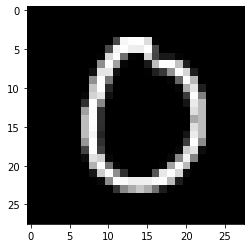

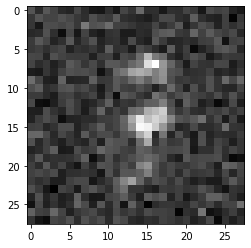

0 10883.225 10883.172 0.053784855


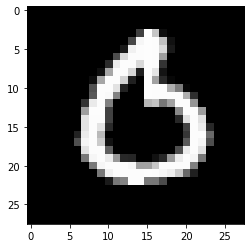

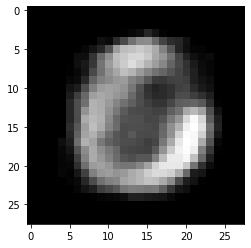

200 2381.224 2355.2778 25.9462


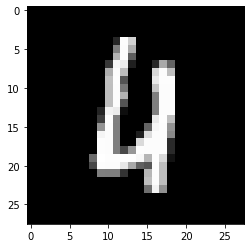

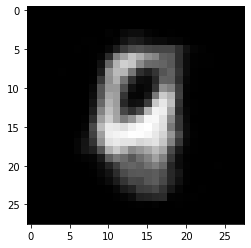

400 1579.3267 1548.6062 30.720482


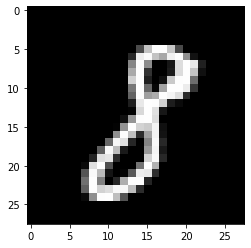

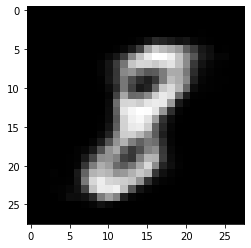

600 1347.8411 1318.0638 29.777264


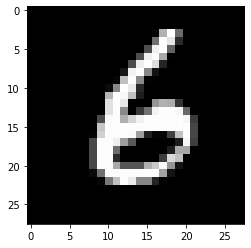

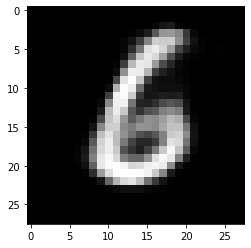

800 1148.626 1115.9949 32.63118


In [11]:
for i in range(1000):
    batch = np.array([np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]])

    sess.run(optimizer, feed_dict = {X: batch})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, loss1, loss2, mn, sd], feed_dict = {X: batch})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

## Exercise 2

According to what we know about the VAE, try to complete the following cell so that the variable "imgs" contains samples generated by the model.

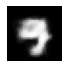

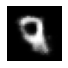

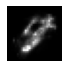

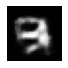

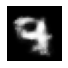

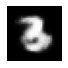

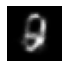

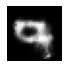

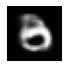

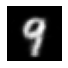

In [13]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')

## Exercise 3

Change the provided implementation of the convolutional VAE so that you can generate new coin images. The input of the decoder should have the following dimensions: [10, 10, 3]. You will need to modify the "reshaped_dim" and "inputs_decoder" variables accordingly. I should also have 100 latent units.

In [34]:
x_train = np.load('coin_images.npy')
x_train = x_train/255
x_train = x_train.reshape(-1, 50, 50)
x_train.shape

(2588, 50, 50)

In [35]:
tf.reset_default_graph()

batch_size = 64

X = tf.placeholder(dtype=tf.float32, shape=[None, 50, 50], name='X')

dec_in_channels = 3
n_latent = 100

reshaped_dim = [-1, 10, 10, dec_in_channels]
inputs_decoder = 100 * dec_in_channels / 2


def lrelu(x, alpha=0.3):  # Leacky relu is an alternative for regular ReLU
    return tf.maximum(x, tf.multiply(x, alpha))

In [36]:
def encoder(X_in):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 50, 50, 1])
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        x = tf.contrib.layers.flatten(x)
        aux1 = tf.layers.dense(x, units=n_latent)
        aux2 = 0.5 * tf.layers.dense(x, units=n_latent)            
        aux3 = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        aux4 = aux1 + tf.multiply(aux3, tf.exp(aux2))
        
        return aux4, aux1, aux2

In [37]:
def decoder(sampled_z):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        x = tf.layers.dense(x, units=inputs_decoder * 2, activation=lrelu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=50*50, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 50, 50])
        return img

In [38]:
sampled, mn, sd = encoder(X)
dec = decoder(sampled)

In [39]:
loss1 = tf.reduce_sum(tf.squared_difference(X, dec))
loss2 = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(loss1 + loss2)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

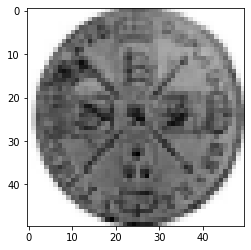

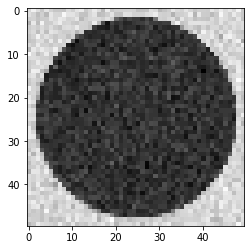

0 25519.553 25518.121 1.4316036


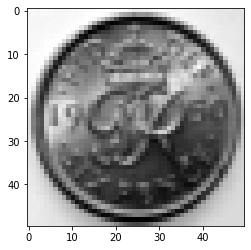

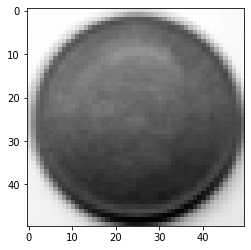

200 3509.945 3362.7917 147.15321


KeyboardInterrupt: 

In [40]:
for i in range(1000):
    indices = np.random.choice(x_train.shape[0], size=150)
    batch = x_train[indices]

    sess.run(optimizer, feed_dict = {X: batch})
        
    if not i % 200:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, loss1, loss2, mn, sd], feed_dict = {X: batch})
        plt.imshow(np.reshape(batch[0], [50, 50]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

In [ ]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {samples: randoms})
imgs = [np.reshape(imgs[i], [50, 50]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')